<a href="https://colab.research.google.com/github/Victorengine/AI-RESEARCH/blob/main/llm_migration_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TensorFlow BERT Encoder Block

In [1]:
import tensorflow as tf

class BertEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(BertEncoderBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)


In [2]:
## Test the Encoder Block with Dummy Input
dummy_input = tf.random.uniform((1,10,64))
block = BertEncoderBlock(embed_dim=64, num_heads=4, ff_dim=128)
output = block(dummy_input, training= False)
print("Output shape:", output.shape)

Output shape: (1, 10, 64)


## Rebuilding the Same Encoder in JAX/Flax

In [3]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from typing import Any

class FlaxBertEncoderBlock (nn.Module):
  embed_dim: int
  num_heads: int
  ff_dim: int
  dropout_rate: float = 0.1

  @nn.compact
  def __call__(self,x,*,train:bool):
    # Multi-head self-attention
    attn_output = nn.SelfAttention(
        num_heads=self.num_heads,
        qkv_features=self.embed_dim,
        dropout_rate=self.dropout_rate,
        deterministic=not train
    )(x)

    # Residual + LayerNorm
    x = nn.LayerNorm()(x + attn_output)

    # Feedforward MLP
    ff_output = nn.Dense(self.ff_dim)(x)
    ff_output = nn.relu(ff_output)
    ff_output = nn.Dropout(rate=self.dropout_rate, deterministic=not train)(ff_output)
    ff_output = nn.Dense(self.embed_dim)(ff_output)

    # Residual + LayerNorm
    x = nn.LayerNorm()(x + ff_output)

    return x


## TEST Dummy Input in Colab (JAX cell)


In [4]:
import jax.random as random

# Dummy input: batch=1, seq=10, embed=64
x = jnp.ones ((1,10,64))
key1, key2 = random.split(random.PRNGKey(0))

# initiaze Model
model = FlaxBertEncoderBlock(embed_dim=64, num_heads=4, ff_dim=128)
variables = model.init(key1, x, train=False)

## Applying the model
output = model.apply(variables,x, train=False)
print("Output shape:" , output.shape)

Output shape: (1, 10, 64)


# TESTING BOTH MODELS
### DATASET GENERATION

In [5]:
import numpy as np
import tensorflow as tf

def generate_synthetic_data(batch_size=256, seq_len=10, embed_dim=64):
  X = np.random.rand(batch_size, seq_len, embed_dim).astype(np.float32)
  y = np.random.randint(0,2, size=(batch_size, seq_len))
  return X, y

X_train, y_train = generate_synthetic_data()


In [6]:
## TRAINING TEnsorflow
inputs = tf.keras.Input(shape=(10, 64))
x = BertEncoderBlock(embed_dim=64, num_heads=4, ff_dim=128)(inputs, training=True)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model_tf = tf.keras.Model(inputs=inputs, outputs=x)
model_tf.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

history_tf = model_tf.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4831 - loss: 1.0605
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4933 - loss: 0.7809
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5112 - loss: 0.7273
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5053 - loss: 0.7083
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5056 - loss: 0.7036


In [7]:
preds_tf = model_tf.predict(X_train[:1])
print("Predicted class distribution (TF):", preds_tf[0, 0])  # first token of first sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Predicted class distribution (TF): [0.5316486  0.46835136]


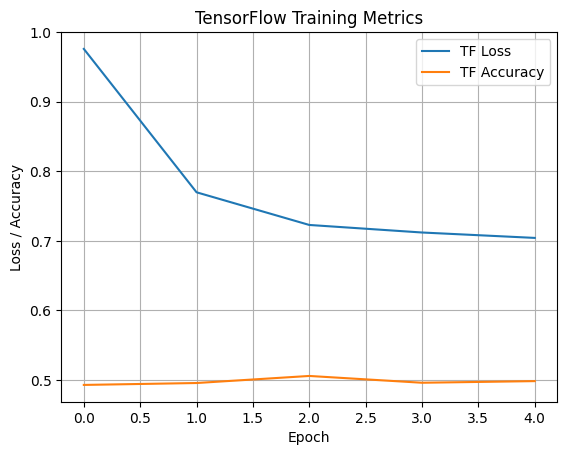

In [8]:
## Visualization of Loss
import matplotlib.pyplot as plt

plt.plot(history_tf.history['loss'], label='TF Loss')
plt.plot(history_tf.history['accuracy'], label='TF Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.title("TensorFlow Training Metrics")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
!pip install flax optax --quiet


In [10]:
import jax
import jax.numpy as jnp
import optax
from flax.training import train_state
from flax import linen as nn

# Reuse your model
class FlaxBertEncoderBlock(nn.Module):
    embed_dim: int
    num_heads: int
    ff_dim: int
    dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, x, *, train: bool):
        attn_output = nn.SelfAttention(
            num_heads=self.num_heads,
            qkv_features=self.embed_dim,
            dropout_rate=self.dropout_rate,
            deterministic=not train
        )(x)
        x = nn.LayerNorm()(x + attn_output)
        ff_output = nn.Dense(self.ff_dim)(x)
        ff_output = nn.relu(ff_output)
        ff_output = nn.Dropout(rate=self.dropout_rate, deterministic=not train)(ff_output)
        ff_output = nn.Dense(self.embed_dim)(ff_output)
        x = nn.LayerNorm()(x + ff_output)
        x = nn.Dense(2)(x)  # token-level 2-class classification
        return x

# Model init
model = FlaxBertEncoderBlock(embed_dim=64, num_heads=4, ff_dim=128)
rng = jax.random.PRNGKey(0)
params = model.init(rng, jnp.ones((1, 10, 64)), train=True)

# Training state
def create_train_state(model, learning_rate):
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


In [14]:
def compute_loss(params, batch_x, batch_y, rng):
    logits = model.apply(
        params,
        batch_x,
        train=True,
        rngs={"dropout": rng}  # 👈 Add this!
    )
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, batch_y)
    return loss.mean()


@jax.jit
def train_step(state, batch_x, batch_y, rng):
    loss_fn = lambda params: compute_loss(params, batch_x, batch_y, rng)
    grads = jax.grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss_fn(state.params)


In [15]:
rng = jax.random.PRNGKey(42)

for epoch in range(5):
    rng, step_rng = jax.random.split(rng)
    state, loss = train_step(state, X_train_jax, y_train_jax, step_rng)
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


Epoch 1, Loss: 0.8747
Epoch 2, Loss: 0.7800
Epoch 3, Loss: 0.8186
Epoch 4, Loss: 0.7759
Epoch 5, Loss: 0.7378


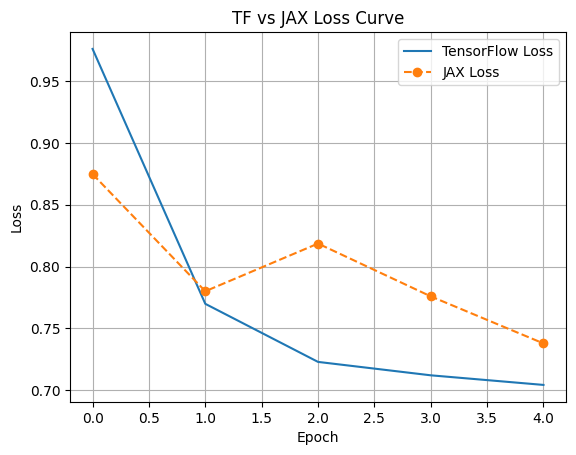

In [16]:
plt.plot(history_tf.history['loss'], label='TensorFlow Loss')
plt.plot(losses, label='JAX Loss', linestyle='--', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TF vs JAX Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


## OPTIMIZING JAX

In [17]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
import numpy as np
from typing import Any

# 🧱 Flax BERT Encoder Block with Xavier Init
class FlaxBertEncoderBlock(nn.Module):
    embed_dim: int
    num_heads: int
    ff_dim: int
    dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, x, *, train: bool):
        initializer = nn.initializers.xavier_uniform()

        attn_output = nn.SelfAttention(
            num_heads=self.num_heads,
            qkv_features=self.embed_dim,
            dropout_rate=self.dropout_rate,
            deterministic=not train,
            kernel_init=initializer
        )(x)
        x = nn.LayerNorm()(x + attn_output)

        ff_output = nn.Dense(self.ff_dim, kernel_init=initializer)(x)
        ff_output = nn.relu(ff_output)
        ff_output = nn.Dropout(rate=self.dropout_rate, deterministic=not train)(ff_output)
        ff_output = nn.Dense(self.embed_dim, kernel_init=initializer)(ff_output)

        x = nn.LayerNorm()(x + ff_output)
        x = nn.Dense(2, kernel_init=initializer)(x)  # 2-class token classifier
        return x


In [18]:
def generate_synthetic_data(batch_size=256, seq_len=10, embed_dim=64):
    X = np.random.rand(batch_size, seq_len, embed_dim).astype(np.float32)
    y = np.random.randint(0, 2, size=(batch_size, seq_len))
    return X, y

X_train_np, y_train_np = generate_synthetic_data()
X_train = jnp.array(X_train_np)
y_train = jnp.array(y_train_np)


In [19]:
def create_train_state(model, rng, learning_rate=0.001):
    params = model.init(rng, jnp.ones((1, 10, 64)), train=True)

    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=learning_rate,
        warmup_steps=5,
        decay_steps=15,
        end_value=learning_rate * 0.1
    )

    tx = optax.chain(
        optax.add_decayed_weights(1e-4),   # L2 regularization
        optax.adam(schedule)
    )

    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=tx
    )


In [20]:
def compute_loss(params, x, y, rng):
    logits = model.apply(params, x, train=True, rngs={"dropout": rng})
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, y)
    return loss.mean()

@jax.jit
def train_step(state, x, y, rng):
    def loss_fn(params):
        return compute_loss(params, x, y, rng)
    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss_fn(state.params)


In [21]:
model = FlaxBertEncoderBlock(embed_dim=64, num_heads=4, ff_dim=128, dropout_rate=0.1)
rng = jax.random.PRNGKey(0)
state = create_train_state(model, rng)

losses = []
for epoch in range(15):
    rng, step_rng = jax.random.split(rng)
    state, loss = train_step(state, X_train, y_train, step_rng)
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


Epoch 1, Loss: 0.9118
Epoch 2, Loss: 0.8402
Epoch 3, Loss: 0.7961
Epoch 4, Loss: 0.8787
Epoch 5, Loss: 0.9613
Epoch 6, Loss: 0.8949
Epoch 7, Loss: 0.8116
Epoch 8, Loss: 0.7606
Epoch 9, Loss: 0.7623
Epoch 10, Loss: 0.7750
Epoch 11, Loss: 0.7888
Epoch 12, Loss: 0.7787
Epoch 13, Loss: 0.7751
Epoch 14, Loss: 0.7606
Epoch 15, Loss: 0.7604


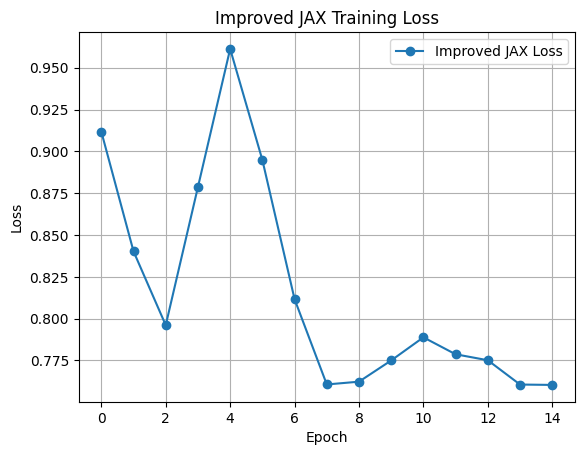

In [22]:
plt.plot(losses, label="Improved JAX Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Improved JAX Training Loss")
plt.grid(True)
plt.legend()
plt.show()


In [23]:
x_input = X_train_np[:1]  # (1, 10, 64)

# TF Predictions (shape: [1, 10, 2])
tf_preds = model_tf.predict(x_input)[0]  # remove batch dim → shape: [10, 2]

# JAX Predictions
x_input_jax = jnp.array(x_input)
jax_preds = model.apply(state.params, x_input_jax, train=False)
jax_preds = np.array(jax_preds[0])  # remove batch dim → shape: [10, 2]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


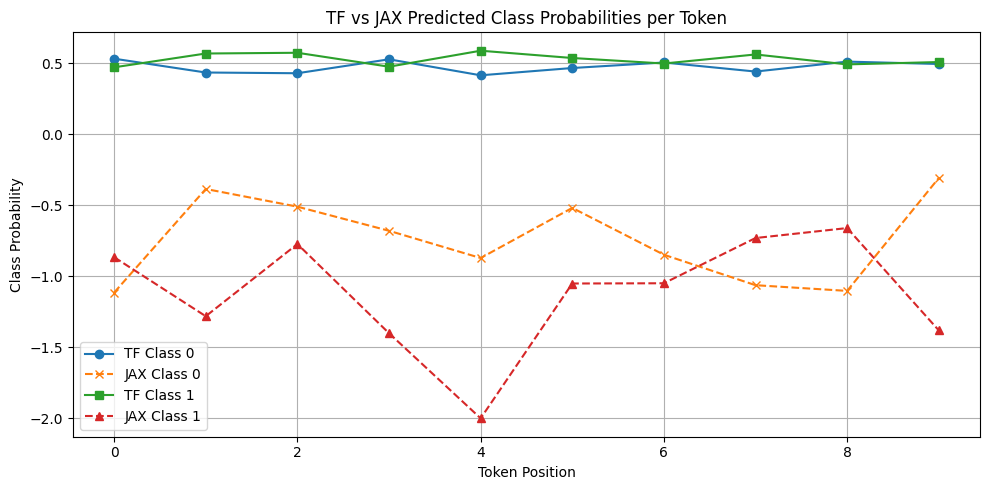

In [24]:
import matplotlib.pyplot as plt

positions = range(10)  # 10 tokens
plt.figure(figsize=(10, 5))

# Class 0 probabilities
plt.plot(positions, tf_preds[:, 0], label="TF Class 0", marker='o')
plt.plot(positions, jax_preds[:, 0], label="JAX Class 0", marker='x', linestyle='--')

# Class 1 probabilities
plt.plot(positions, tf_preds[:, 1], label="TF Class 1", marker='s')
plt.plot(positions, jax_preds[:, 1], label="JAX Class 1", marker='^', linestyle='--')

plt.title("TF vs JAX Predicted Class Probabilities per Token")
plt.xlabel("Token Position")
plt.ylabel("Class Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
